## Denoising Autoencoders
Autoencoders are a group of unsupervised learning models. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction and then generate from the reduced encoding, a representation as close as possible to its original input data (decoding). As such it has two main networks, an encoder and a decoder. In this example, we will construct a convolutional autoencoder to denoise images. We start out with noisy image data as the input and their clean counterparts as the output to train the autoencoder. Once the autoencoder is trained, the model can be validated on a holdout sample. The noisy images were artificially generated by applying salt-and-pepper noise. 

## Import Relevant Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from swat import *
from dlpy import Model, Sequential
from dlpy.layers import *
from dlpy.applications import *
from dlpy.utils import *
from dlpy.images import ImageTable
from dlpy.splitting import two_way_split
from dlpy.model import *
from dlpy.blocks import *
warnings.filterwarnings('ignore')

## Start a CAS session

In [2]:
s = CAS("host", "port", "user","password") 

## Load Relevant Actionsets

In [3]:
s.loadactionset('image')
s.loadactionset('deepLearn')

NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.00227s, user: 0.000304s, sys: 0.0011s, mem: 0.221mb

## Specify CASLIB and Load Data

In [6]:
s.table.addcaslib(activeonadd=False,datasource={'srctype':'path'},name='dnfs',path='/mypath', subdirectories=True)

my_images = s.table.loadtable(casout={'name':'trainSet', 'replace':True, 'blocksize':350},
                                               caslib = 'dnfs', path='Giraffe_clean_dirty_224.sashdat')
s.columninfo('trainSet')

NOTE: Cloud Analytic Services made the file Giraffe_clean_dirty_224.sashdat available as table TRAINSET in caslib dnfs.


[ColumnInfo]

      Column Label  ID              Type  RawLength  FormattedLength Format  \
 0  filename         1              char         28               28          
 1   _image_         2  varbinary(image)      52964            52964          
 2    _size_         3             int64          8               12          
 3    _path_         4           varchar         65               65          
 4    _type_         5              char          3                3          
 5      _id_         6             int64          8               12          
 6   _label_         7           varchar          0                1          
 7  outimage         8  varbinary(image)      51671            51671          
 
    NFL  NFD  
 0    0    0  
 1    0    0  
 2    0    0  
 3    0    0  
 4    0    0  
 5    0    0  
 6    0    0  
 7    0    0  

+ Elapsed: 0.000333s, user: 0.000178s, sys: 0.000148s, mem: 0.803mb

## Summarizeimages 
Both sets of images in the table are resized to 224*224

In [7]:
s.summarizeimages(table='trainset', image='outimage')

NOTE: Table TRAINSET contains compressed images.
NOTE: 172 out of 172 images were scanned and results were saved to the summary table.


[Summary]

      Column    jpg  minWidth  maxWidth  minHeight  maxHeight  meanWidth  \
 0  outimage  172.0     224.0     224.0      224.0      224.0      224.0   
 
    meanHeight  mean1stChannel  min1stChannel  max1stChannel  mean2ndChannel  \
 0       224.0       95.232935            0.0          255.0      119.702824   
 
    min2ndChannel  max2ndChannel  mean3rdChannel  min3rdChannel  max3rdChannel  
 0            0.0          255.0      120.085838            0.0          255.0  

+ Elapsed: 0.0345s, user: 0.239s, sys: 0.0306s, mem: 3.81mb

## Display noisy and clean images

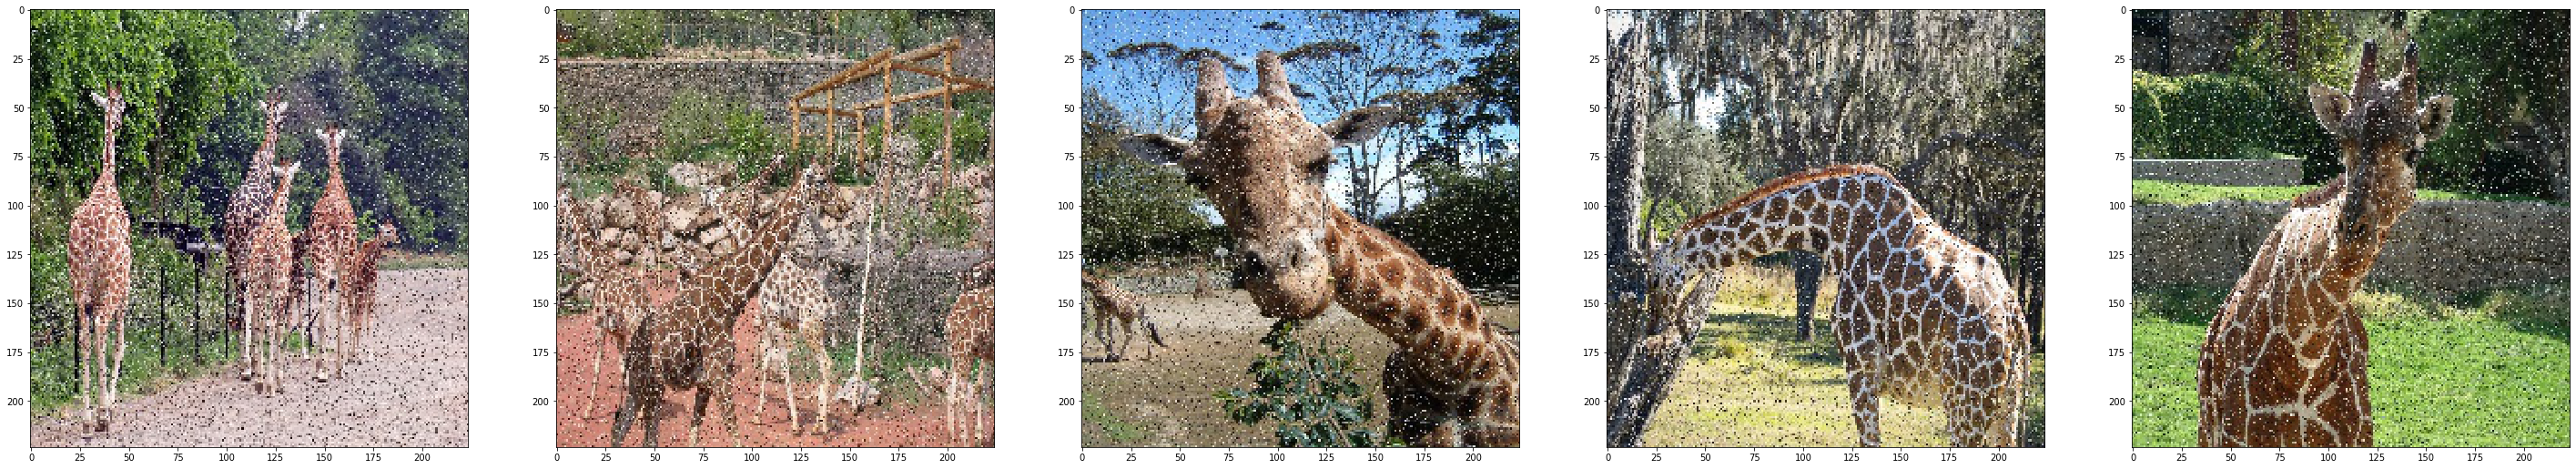

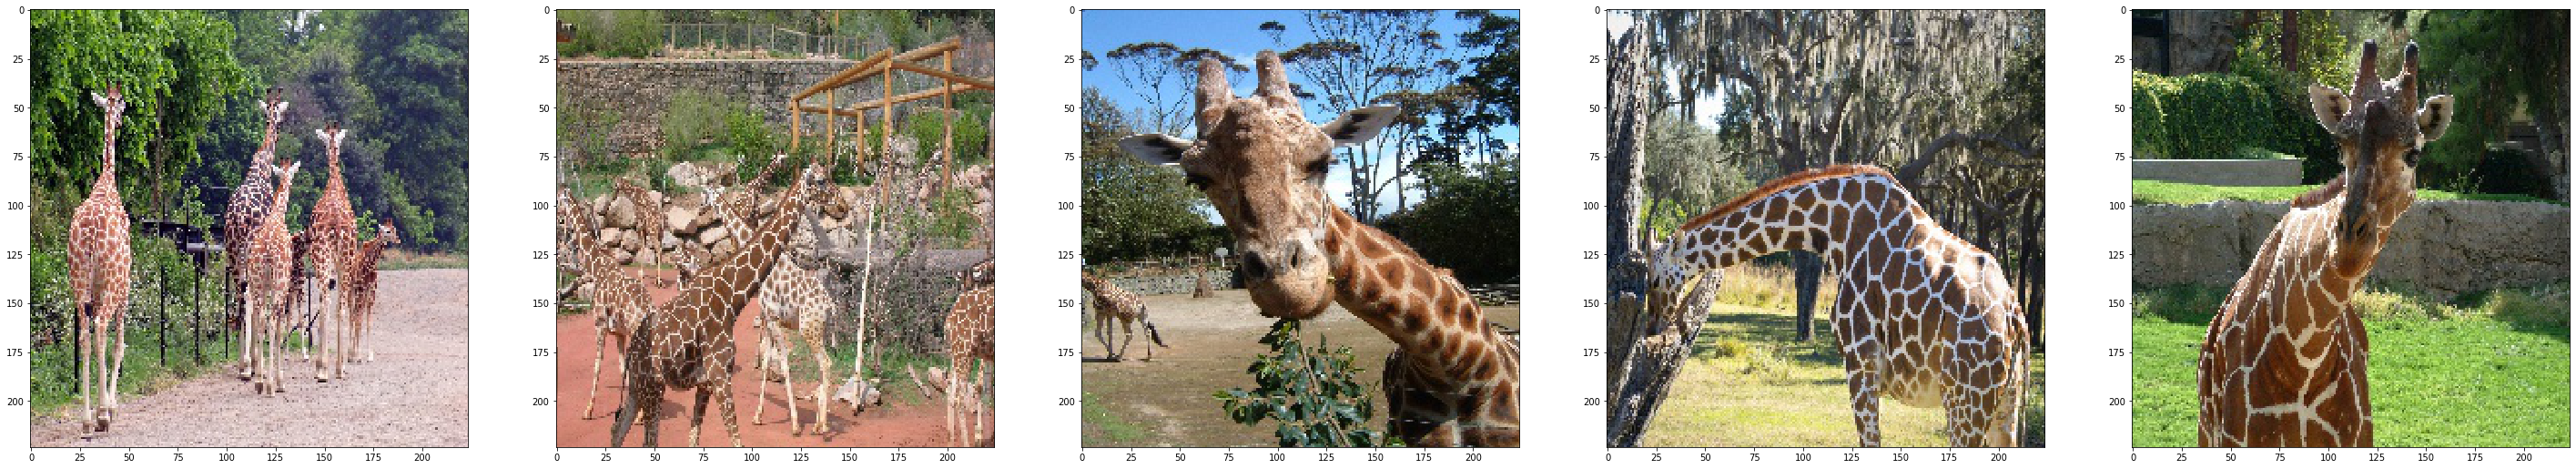

In [8]:
# Display 5 noisy pictures.
display_segmentation_images(s, 'trainset', n_images=5, image_column='_image_', 
                            segmentation_labels_table='trainset', label_column='_label_')
# Display 5 corresponding clean pictures.
display_segmentation_images(s, 'trainset', n_images=5, image_column='outimage', 
                            segmentation_labels_table='trainset', label_column='_label_')

## Define Autoencoder architecture

In [9]:
nf = 1024


data_input = Input(n_channels=3, width=224, height=224, name='Input', scale = 1.0 / 255)
conv_1 = Conv2d(n_filters=nf, width=3, height=3, stride=1, padding=1, act='elu')(data_input)
pool_1 = Pooling(width=2, height=2, stride=2, padding=0, pool='max')(conv_1)
conv_2 = Conv2d(n_filters=nf/2, width=3, height=3, stride=1, padding=1, act='elu')(pool_1)
pool_2 = Pooling(width=2, height=2, stride=2, padding=0, pool='max')(conv_2)
conv_3 = Conv2d(n_filters=nf/2, width=3, height=3, stride=1, padding=1, act='elu')(pool_2)

conv_4 = Conv2d(n_filters=nf, width=3, height=3, stride=1, padding=1, act='elu')(conv_3)
pool_3 = Pooling(width=2, height=2, stride=2, padding=0, pool='max')(conv_4)
conv_5 = Conv2d(n_filters=nf/2, width=3, height=3, stride=1, padding=1, act='elu')(pool_3)
pool_4 = Pooling(width=2, height=2, stride=2, padding=0, pool='max')(conv_5)
conv_6 = Conv2d(n_filters=nf/2, width=3, height=3, stride=1, padding=1, act='elu')(pool_4)


encoder = Pooling(width=3, height=3, stride=2, padding=1, pool='max', name='encoder')(conv_6)

conv_7 = Conv2d(n_filters=nf/2, width=3, height=3, stride=1, padding=1, act='elu')(encoder)
upsample_1 = Conv2DTranspose(nf/2, 4, padding=1, stride=2, act='relu')(conv_7)
conv_8 = Conv2d(n_filters=nf/2, width=3, height=3, stride=1, padding=1, act='elu')(upsample_1)
upsample_2 = Conv2DTranspose(nf/2, 4, padding=1, stride=2, act='relu')(conv_8)
conv_9 = Conv2d(n_filters=nf, width=3, height=3, stride=1, padding=1, act='elu')(upsample_2)
upsample_3 = Conv2DTranspose(nf, 4, padding=1, stride=2, act='relu')(conv_9)

conv_10 = Conv2d(n_filters=nf/2, width=3, height=3, stride=1, padding=1, act='elu')(upsample_3)
upsample_4 = Conv2DTranspose(nf/2, 4, padding=1, stride=2, act='relu')(conv_10)
conv_11 = Conv2d(n_filters=nf/2, width=3, height=3, stride=1, padding=1, act='elu')(upsample_4)
upsample_5 = Conv2DTranspose(nf, 4, padding=1, stride=2, act='relu')(conv_11)



decoder = Conv2d(n_filters=3, width=3, height=3, stride=1, padding=1, act='logistic', name='decoder')(upsample_5)

seg1 = Segmentation(name='Segmentation_1', target_scale = 1.0 / 255, error='normal')(decoder)
model = Model(s, inputs=data_input, outputs=seg1, model_table='auto_encoder')
model.compile()
model.summary

NOTE: Model compiled successfully.


Layer Id              Layer          Type Kernel Size  Stride Activation  \
0          0              Input         input                           None   
1          1           Conv2d_1         convo      (3, 3)  (1, 1)        Elu   
2          2          Pooling_1          pool      (2, 2)  (2, 2)        Max   
3          3           Conv2d_2         convo      (3, 3)  (1, 1)        Elu   
4          4          Pooling_2          pool      (2, 2)  (2, 2)        Max   
5          5           Conv2d_3         convo      (3, 3)  (1, 1)        Elu   
6          6           Conv2d_4         convo      (3, 3)  (1, 1)        Elu   
7          7          Pooling_3          pool      (2, 2)  (2, 2)        Max   
8          8           Conv2d_5         convo      (3, 3)  (1, 1)        Elu   
9          9          Pooling_4          pool      (2, 2)  (2, 2)        Max   
10        10           Conv2d_6         convo      (3, 3)  (1, 1)        Elu   
11        11            encoder          pool      (3, 3)  (2, 2)        Max   
12        12           Conv2d_7         convo      (3, 3)  (1, 1)        Elu   
13        13  Conv2DTranspose_1    transconvo      (4, 4)  (2, 2)       Relu   
14        14           Conv2d_8         convo      (3, 3)  (1, 1)        Elu   
15        15  Conv2DTranspose_2    transconvo      (4, 4)  (2, 2)       Relu   
16        16           Conv2d_9         convo      (3, 3)  (1, 1)        Elu   
17        17  Conv2DTranspose_3    transconvo      (4, 4)  (2, 2)       Relu   
18        18          Conv2d_10         convo      (3, 3)  (1, 1)        Elu   
19        19  Conv2DTranspose_4    transconvo      (4, 4)  (2, 2)       Relu   
20        20          Conv2d_11         convo      (3, 3)  (1, 1)        Elu   
21        21  Conv2DTranspose_5    transconvo      (4, 4)  (2, 2)       Relu   
22        22            decoder         convo      (3, 3)  (1, 1)   Logistic   
23        23     Segmentation_1  segmentation                           None   

         Output Size Number of Parameters  FLOPS(forward pass)  
0      (224, 224, 3)               (0, 0)                    0  
1   (224, 224, 1024)        (27648, 1024)           1387266048  
2   (112, 112, 1024)               (0, 0)                    0  
3    (112, 112, 512)       (4718592, 512)          59190018048  
4      (56, 56, 512)               (0, 0)                    0  
5      (56, 56, 512)       (2359296, 512)           7398752256  
6     (56, 56, 1024)      (4718592, 1024)          14797504512  
7     (28, 28, 1024)               (0, 0)                    0  
8      (28, 28, 512)       (4718592, 512)           3699376128  
9      (14, 14, 512)               (0, 0)                    0  
10     (14, 14, 512)       (2359296, 512)            462422016  
11       (7, 7, 512)               (0, 0)                    0  
12       (7, 7, 512)       (2359296, 512)            115605504  
13     (14, 14, 512)       (4194304, 512)            822083584  
14     (14, 14, 512)       (2359296, 512)            462422016  
15     (28, 28, 512)       (4194304, 512)           3288334336  
16    (28, 28, 1024)      (4718592, 1024)           3699376128  
17    (56, 56, 1024)     (16777216, 1024)          52613349376  
18     (56, 56, 512)       (4718592, 512)          14797504512  
19   (112, 112, 512)       (4194304, 512)          52613349376  
20   (112, 112, 512)       (2359296, 512)          29595009024  
21  (224, 224, 1024)      (8388608, 1024)         420906795008  
22     (224, 224, 3)           (27648, 3)           1387266048  
23     (224, 224, 3)               (0, 0)                    0

## Partition the data into training and validation sets

In [10]:
# Training and validation
shuffleidSASCode = "call streaminit(-1);shuffle_id=rand(\"UNIFORM\");"
trainTbl0 = s.CASTable('trainset', computedvars=['shuffle_id'], computedvarsprogram=shuffleidSASCode, 
                       where='shuffle_id>0.25',
                       groupby='shuffle_id'
                      )
s.partition(table=trainTbl0, casout=dict(name='train_sampled', replace=True))

valiTbl0 = s.CASTable('trainset', computedvars=['shuffle_id'], computedvarsprogram=shuffleidSASCode, 
                       where='shuffle_id<0.25',
                       groupby='shuffle_id'
                      )
s.partition(table=valiTbl0, casout=dict(name='vali_sampled', replace=True))

[caslib]

 'dnfs'

[tableName]

 'VALI_SAMPLED'

[rowsTransferred]

 0

[shuffleWaitTime]

 0.0

[minShuffleWaitTime]

 1e+300

[maxShuffleWaitTime]

 0.0

[averageShuffleWaitTime]

 0.0

[casTable]

 CASTable('VALI_SAMPLED', caslib='dnfs')

+ Elapsed: 0.0194s, user: 0.0137s, sys: 0.0992s, mem: 75.3mb

## Specify dataspecs and solver options

In [12]:
data_specs = [DataSpec(type_='IMAGE', layer='Input', data=['_image_']),
              DataSpec(type_='IMAGE', layer='Segmentation_1', data=['outimage'])]


solver = AdamSolver(lr_scheduler=StepLR(learning_rate=0.0001, 
                                        step_size=150, 
                                        gamma=0.8), 
                    clip_grad_max = 100, 
                    clip_grad_min = -100)
optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=10, 
                      log_level=2, 
                      max_epochs=300, 
                      reg_l2=0.001, 
                      seed=13309)

r = model.fit(data = 'train_sampled', valid_table='vali_sampled',
              data_specs=data_specs, 
              optimizer=optimizer, 
              force_equal_padding=True, 
              n_threads=1, gpu=True)

The following argument(s) learning_rate, learning_rate_policy, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.
NOTE: Training from scratch.
NOTE: Using dlgrd008.unx.sas.com: 2 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 73204227.
NOTE:  The approximate memory cost is 12660.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost      10.11 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 10.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 10.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  0        0.0001            5065     0.2175             5002           0.2188    96.55
NOTE:  1        0.0001      

NOTE:  83       0.0001           969.9    0.08488             1072          0.08846    34.74
NOTE:  84       0.0001            1016    0.08666             1074          0.08889    34.74
NOTE:  85       0.0001            1007    0.08627             1050          0.08697    34.73
NOTE:  86       0.0001           947.8     0.0839             1036          0.08639    34.74
NOTE:  87       0.0001           977.4    0.08472             1028           0.0864    34.74
NOTE:  88       0.0001           922.3    0.08239             1015           0.0868    34.75
NOTE:  89       0.0001           977.7    0.08525             1005          0.08476    34.73
NOTE:  90       0.0001             906    0.08147            988.9          0.08445    34.74
NOTE:  91       0.0001             901    0.08144            981.1           0.0842    34.75
NOTE:  92       0.0001           886.2    0.08084            974.3          0.08457    34.75
NOTE:  93       0.0001           910.1    0.08203            992.7    

NOTE:  173      0.0001           260.3     0.0451            468.2          0.05411    34.75
NOTE:  174      0.0001           277.4    0.04668            492.1          0.05646    34.74
NOTE:  175      0.0001           304.8    0.04917            496.2           0.0568    34.73
NOTE:  176      0.0001           289.5    0.04793            514.4          0.05901    34.75
NOTE:  177      0.0001           380.5    0.05481            638.4          0.06824    34.74
NOTE:  178      0.0001           450.4    0.05993            598.5          0.06491    34.73
NOTE:  179      0.0001           384.4    0.05545            529.3          0.05986    34.74
NOTE:  180      0.0001             316    0.05013            493.3           0.0563    34.75
NOTE:  181      0.0001           279.4    0.04709            463.9          0.05416    34.73
NOTE:  182      0.0001           256.2    0.04499            446.6          0.05249    34.74
NOTE:  183      0.0001           249.7     0.0443            441.5    

NOTE:  264      0.0001           89.25    0.02666            325.1          0.03709    34.75
NOTE:  265      0.0001           85.85    0.02607            319.1          0.03638    34.75
NOTE:  266      0.0001           83.39    0.02563            314.8          0.03583    34.74
NOTE:  267      0.0001           80.97    0.02524            313.8          0.03565    34.74
NOTE:  268      0.0001           76.02    0.02445            312.9          0.03563    34.74
NOTE:  269      0.0001           79.71    0.02504            313.6          0.03547    34.74
NOTE:  270      0.0001           81.78    0.02543              321          0.03634    34.73
NOTE:  271      0.0001           79.03    0.02499            316.8          0.03583    34.74
NOTE:  272      0.0001           77.17    0.02469            319.3          0.03623    34.74
NOTE:  273      0.0001           83.35     0.0257              318          0.03625    34.75
NOTE:  274      0.0001           85.73    0.02617            325.8    

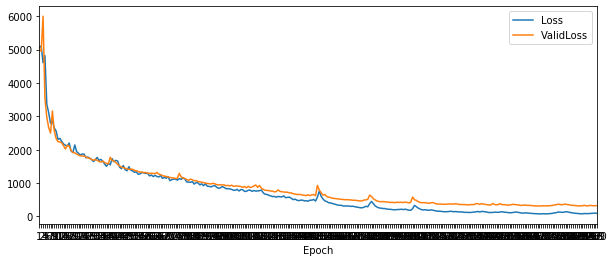

In [13]:
model.plot_training_history(items=['Loss', 'ValidLoss'],fig_size=(10,4))

## Predict on validation data

In [17]:
model.predict('vali_sampled')

NOTE: Due to data distribution, miniBatchSize has been limited to 1.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            52
 1  Number of Observations Used            52
 2          Mean Absolute Error      0.038389
 3                   Loss Error      324.1727

[OutputCasTables]

   casLib              Name  Rows  Columns  \
 0   dnfs  Valid_Res_aOAqpI    52   150537   
 
                                       casTable  
 0  CASTable('Valid_Res_aOAqpI', caslib='dnfs')  

+ Elapsed: 55.7s, user: 2.18e+03s, sys: 55.7s, mem: 1.41e+05mb

## Rename _image_ to _newimage_ 

In [18]:
var = ['_image_']
for i in range(0,1):
    s.table.altertable(columns=[{'rename':'_newimage_', 'name':var[i]}], name=model.valid_res_tbl.name)

## Create the Image column from pixel intensities

In [22]:
s.image.condenseImages(
                            casout={'name':'outimage', 'replace':True} ,
                            table={'name':model.valid_res_tbl.name}, numberOfChannels='COLOR_IMAGE',
                            height=224, width=224, copyvars=['filename', 'outimage', '_newimage_'], groupedChannels=True
)

NOTE: 52 out of 52 images were processed successfully and saved to the Cloud Analytic Services table outimage.


[OutputCasTables]

   casLib      Name Label  Rows  Columns                             casTable
 0   dnfs  outimage          52        8  CASTable('outimage', caslib='dnfs')

+ Elapsed: 1.61s, user: 2.18s, sys: 0.505s, mem: 933mb

## Display images
### Top Row :  Predicted output
### Middle Row: Ground Truth
### Bottom Row: Noisy Input

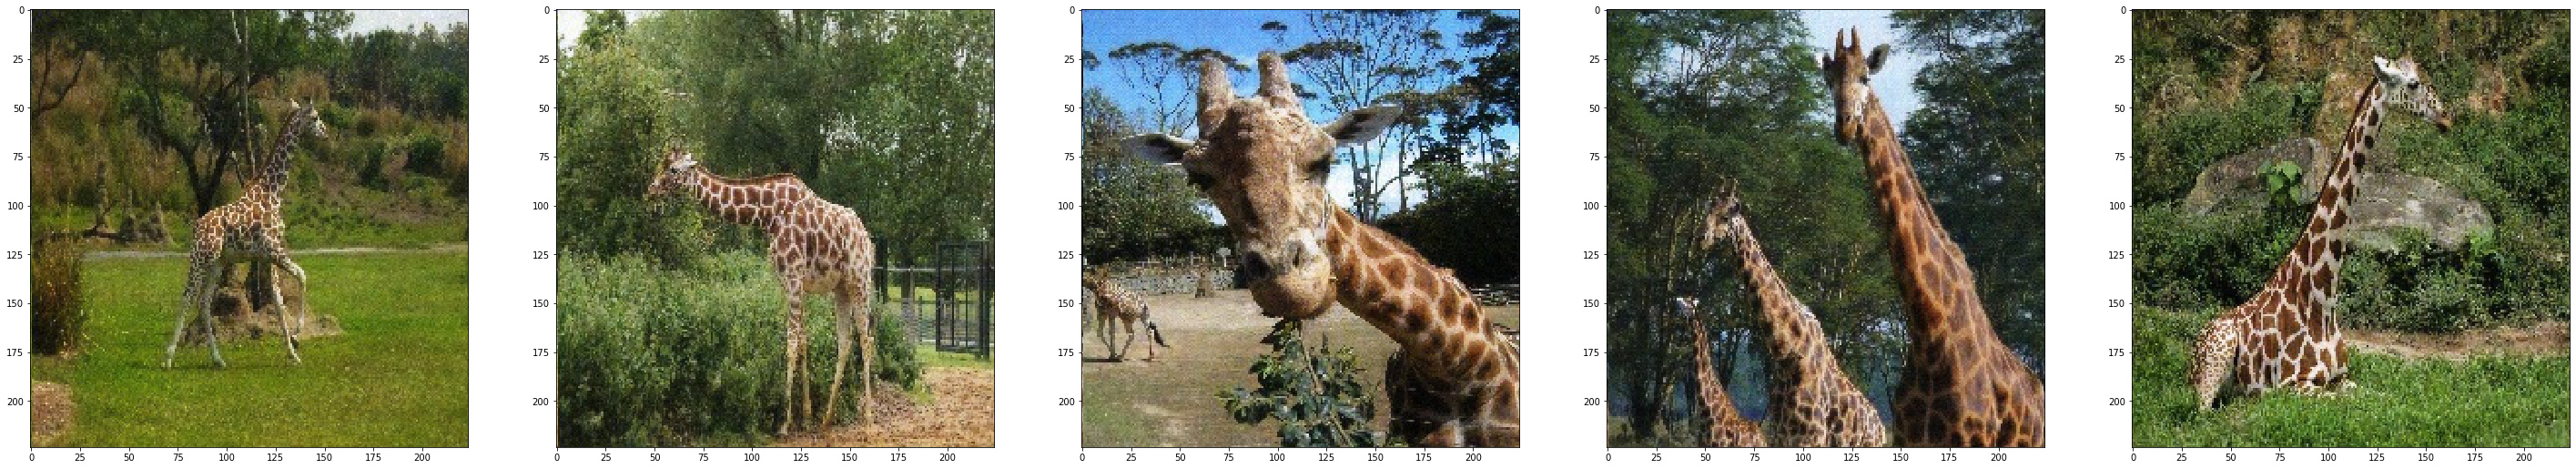

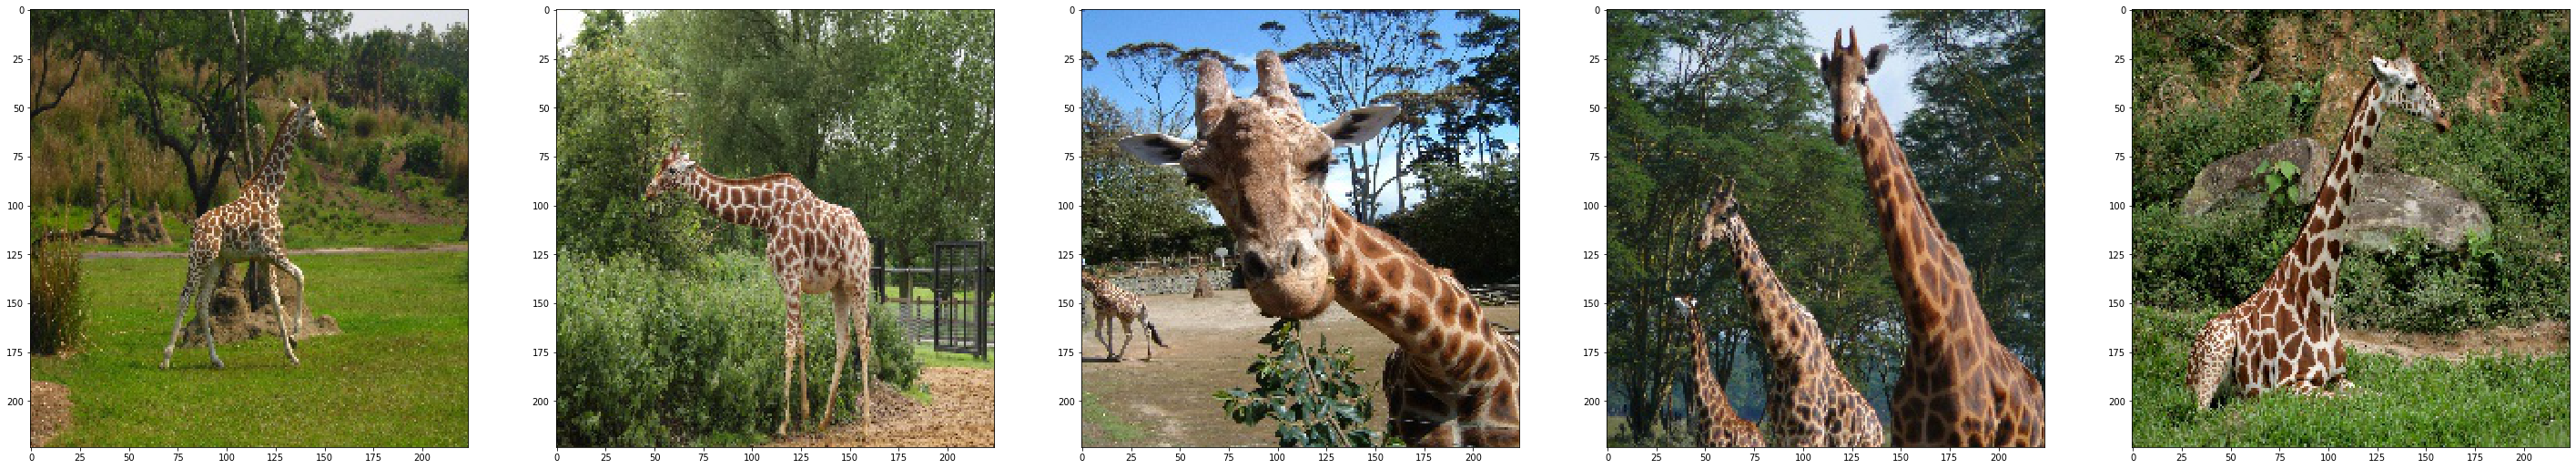

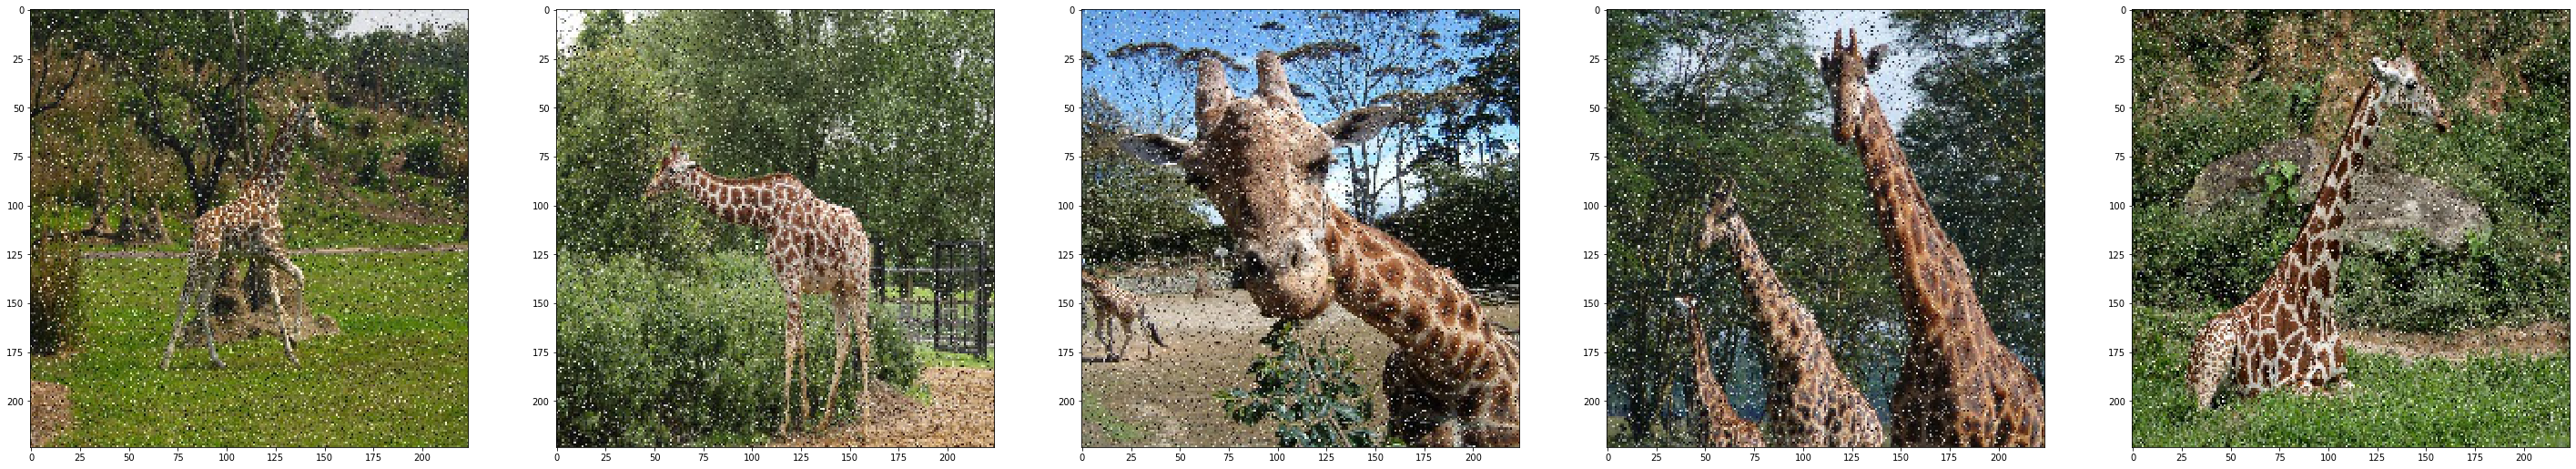

In [24]:
# Display 5 pictures output by model.
display_segmentation_images(s, 'outimage', n_images=5, image_column='_image_', 
                            segmentation_labels_table='outimage', label_column='_label_')
# Display 5 corresponding pictures that correspond to ground truth.
display_segmentation_images(s, 'outimage', n_images=5, image_column='outimage', 
                            segmentation_labels_table='outimage', label_column='_label_')
# Display 5 corresponding input pictures.
display_segmentation_images(s, 'outimage', n_images=5, image_column='_newimage_', 
                            segmentation_labels_table='outimage', label_column='_label_')